# 회귀모델을 통한<br>Turbopan jet engine RUL(잔여수명)예측
---
## 1. 분석목적
이번 프로젝트에서는 GE(제네럴 일렉트릭) Aviation사의 Digital technology/IT 부서의 
머신러닝 엔지니어의 관점에서 기존 또는 향후 개발될 제트엔진의 **RUL을 예측**하여 사전정비를 통한 **기체의 안정성 향상**을 목표로 회귀모델을 만들고자 한다.
## 2. 분석 및 예측의 필요성
- **비행시간과 여객기 운항 수**
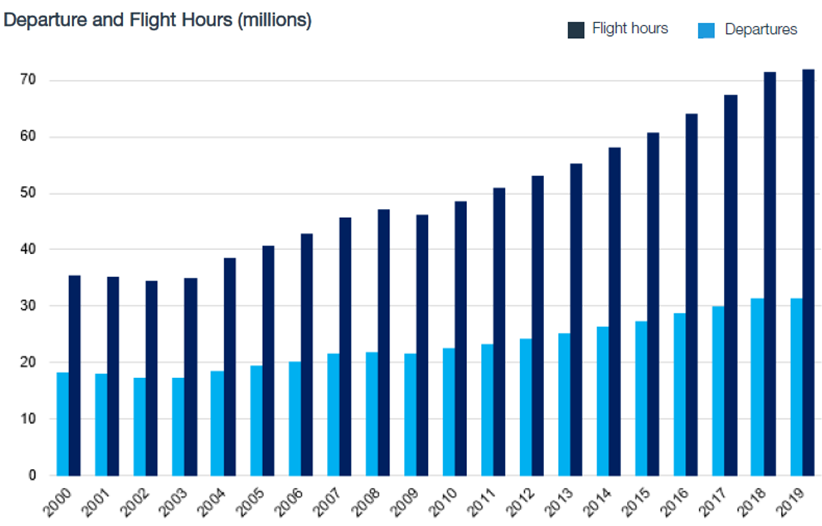

항공기 운항시간과 운항 수는 꾸준히 증가하고 있다. 그리고 이에 따라서 사고의 수 역시 증가할 것 같지만 100만번 운행 시 사고의 횟수는 과학기술의 발달과 많은 사람들의 노력으로 감소하고 있으며 치명적 사고의 비율 역시 감소하고 있다.
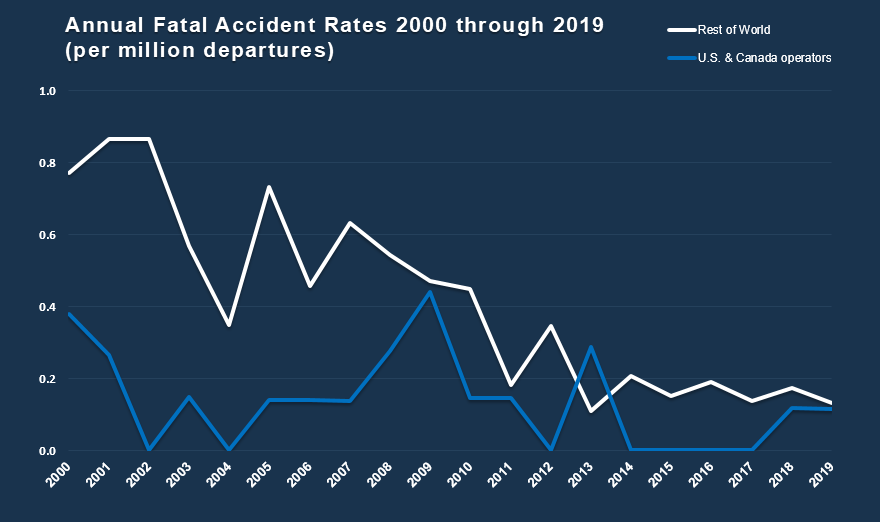
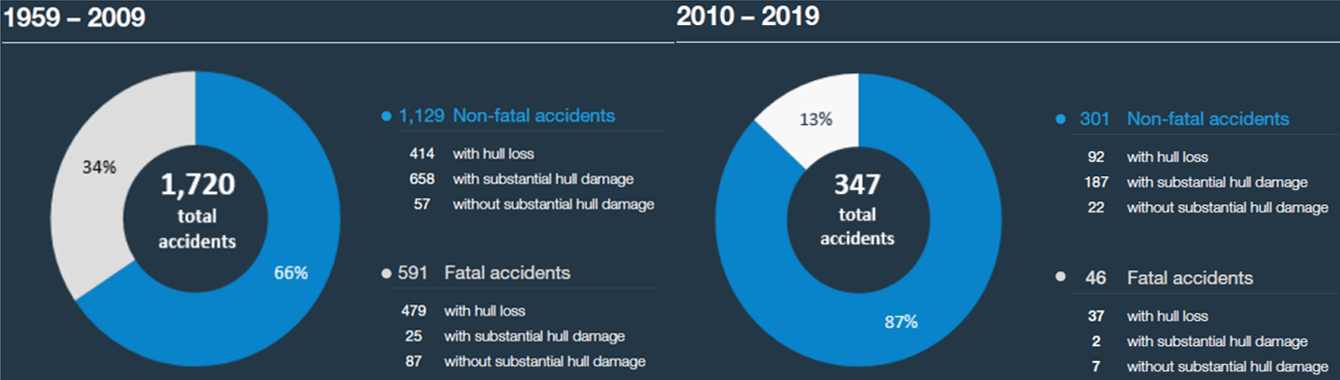
하지만 그렇다하더라도 항공기의 경우 한 번 사고가 발생하면 많은 인명피해를 발생시키기 때문에 보다 안전한 항공기를 만들기 위해서 꾸준한 노력이 필요하다.
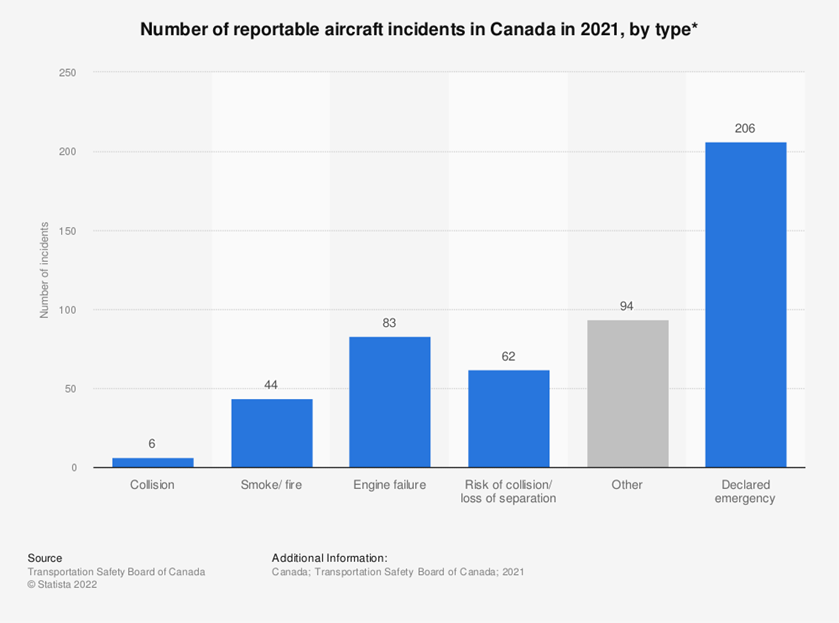
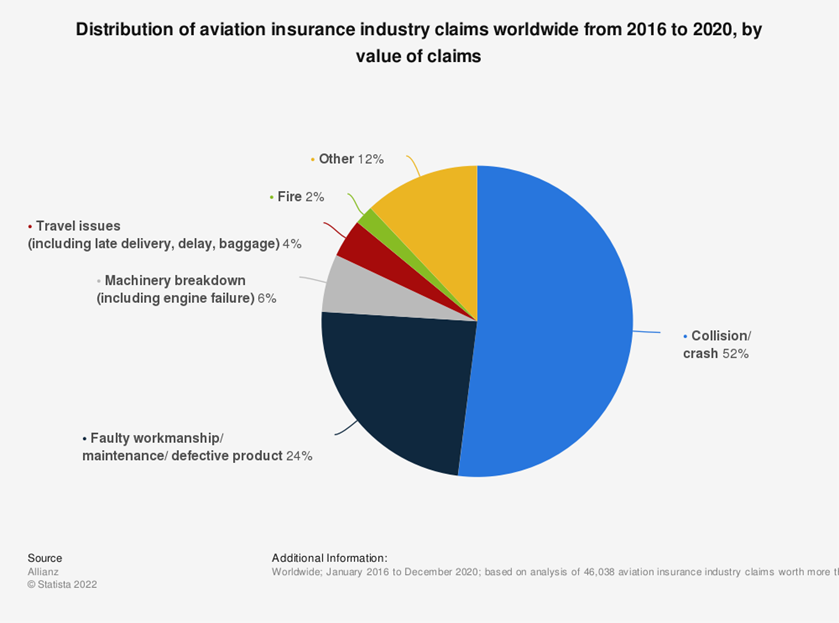
2016년부터 2020년 전세계 항공보험 청구 통계를 보면 잘못된 유지보수, 불량제품, 작업방식 그리고 기계결함이 30%의 비중을 차지하고 있는 것을 확인할 수 있다.
그리고 2021년 캐나다 항공기 사고의 원인 통계를 보면 엔진 결함이 2번째로 높은 빈도를 기록하고 있는 것을 확인할 수 있다.

GE Aviation은 이러한 엔진 결함 및 유지보수 측면에서 안정성을 향상시켜 사고발생률을 낮추기 위해서 엔진의 다양한 센서로부터 입력된 값을 통하여 엔진의 RUL을 예측하고자 한다

## 특성 설명
- 1: Engine
- 2: Cycle
- 3: Setting_1(고도)
- 4: Setting_2(마하수)
- 5: Setting_3(TRA)
- 6: Fan 유입 온도(단위:1°R(란씨),1°R(란씨) = -272.594°C = 0.556K)
- 7: LPC(Low pressure compressor)의 출구온도(단위:1°R(란씨))
- 8: HPC의 출구온도(단위:1°R(란씨))
- 9: LPT의 출구온도(단위:1°R(란씨))
- 10: Fan 유입압력 (psi)
- 11: Bypass-duct 압력 (psi)
- 12: HPC의 출구압력
- 13: Fan의 물리적 회전속도 (RPM)
- 14: Core의 물리적 회전속도 (RPM)
- 15: 엔진 압력비(/Fan의 입구압력)
- 16: HPC의 출구 정압력 (psi)
- 17: Ps30(HPC 출구의 정압력)에 대한 연료흐름비 (pps/psi)
- 18: 수정된 Fan의 회전속도 (RPM)
- 19: 수정된 Core의 회전속도 (RPM)
- 20: Bypass비
- 21: Burner의 연료-공기비
- 22: Bleed 엔탈피
- 23: 필요 Fan 속도
- 24: 필요 Fan Conversion 속도
- 25: 고압 터빈의 냉각공기유동
- 26: 저압 터빈의 냉각공기유동

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sct

In [2]:
col_name = [
    'Engine','Cycle',
    'Setting_1','Setting_2','Setting_3',
    'Fan_inlet_T',
    'LPC_outlet_T',
    'HPC_outlet_T',
    'LPT_outlet_T',
    'Fan_inlet_P',
    'bypass_duct_P',
    'HPC_outlet_P',
    'Physical_fan_speed',
    'Physical_core_speed',
    'Engine_P_R',
    'HPC_outlet_SP',
    'Ratio_of_fuel_flow',
    'Corrected_fan_S',
    'Corrected_core_S',
    'Bypass_R',
    'Burner_f_a_R',
    'BE',
    'Requried_fan_S',
    'Requried_fan_Conv_S',
    'HP_turbines_Caf',
    'LP_turbines_Caf'
]

In [471]:
# 파일 불러오기
# txt파일에서 각 값들이 길이가 정해지지 않은 공백으로 구분되므로 '\s+'사용
train = pd.read_csv('train_FD001.txt',sep = '\s+',names = col_name) 
X_test = pd.read_csv('test_FD001.txt',sep='\s+',names = col_name)
X_test.head(8)

,Engine,Cycle,Setting_1,Setting_2,Setting_3,Fan_inlet_T,LPC_outlet_T,HPC_outlet_T,LPT_outlet_T,Fan_inlet_P,...,Ratio_of_fuel_flow,Corrected_fan_S,Corrected_core_S,Bypass_R,Burner_f_a_R,BE,Requried_fan_S,Requried_fan_Conv_S,HP_turbines_Caf,LP_turbines_Caf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,...,521.92,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467
6,1,7,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,14.62,...,522.01,2388.06,8134.97,8.3914,0.03,391,2388,100.0,38.85,23.3952
7,1,8,0.0006,-0.0000,100.0,518.67,642.54,1580.89,1400.89,14.62,...,522.09,2388.06,8125.93,8.4213,0.03,393,2388,100.0,39.05,23.3224


In [21]:
train.isnull().sum() # 결측치 확인

Engine                 0
Cycle                  0
Setting_1              0
Setting_2              0
Setting_3              0
Fan_inlet_T            0
LPC_outlet_T           0
HPC_outlet_T           0
LPT_outlet_T           0
Fan_inlet_P            0
bypass_duct_P          0
HPC_outlet_P           0
Physical_fan_speed     0
Physical_core_speed    0
Engine_P_R             0
HPC_outlet_SP          0
Ratio_of_fuel_flow     0
Corrected_fan_S        0
Corrected_core_S       0
Bypass_R               0
Burner_f_a_R           0
BE                     0
Requried_fan_S         0
Requried_fan_Conv_S    0
HP_turbines_Caf        0
LP_turbines_Caf        0
dtype: int64

In [22]:
train.duplicated().sum() #중복치 확인

0

In [6]:
train.describe().T # 통계치 확인

,count,mean,std,min,25%,50%,75%,max
Engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
Cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
Setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
Setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
Setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
Fan_inlet_T,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
LPC_outlet_T,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
HPC_outlet_T,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
LPT_outlet_T,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Fan_inlet_P,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Engine               20631 non-null  int64  
 1   Cycle                20631 non-null  int64  
 2   Setting_1            20631 non-null  float64
 3   Setting_2            20631 non-null  float64
 4   Setting_3            20631 non-null  float64
 5   Fan_inlet_T          20631 non-null  float64
 6   LPC_outlet_T         20631 non-null  float64
 7   HPC_outlet_T         20631 non-null  float64
 8   LPT_outlet_T         20631 non-null  float64
 9   Fan_inlet_P          20631 non-null  float64
 10  bypass_duct_P        20631 non-null  float64
 11  HPC_outlet_P         20631 non-null  float64
 12  Physical_fan_speed   20631 non-null  float64
 13  Physical_core_speed  20631 non-null  float64
 14  Engine_P_R           20631 non-null  float64
 15  HPC_outlet_SP        20631 non-null 

결측치 및 중복치가 존재하지 않고, 통계량으로 보았을 때 현재 큰 문제가 생길 수 있는 이상치는 존재하지 않는 것으로 보인다.<br> 
또한 모든 특성의 분산이 그 크기를 고려했을 때 분산이 다르다고 할 수도 없을 것 같다고 판단된다.

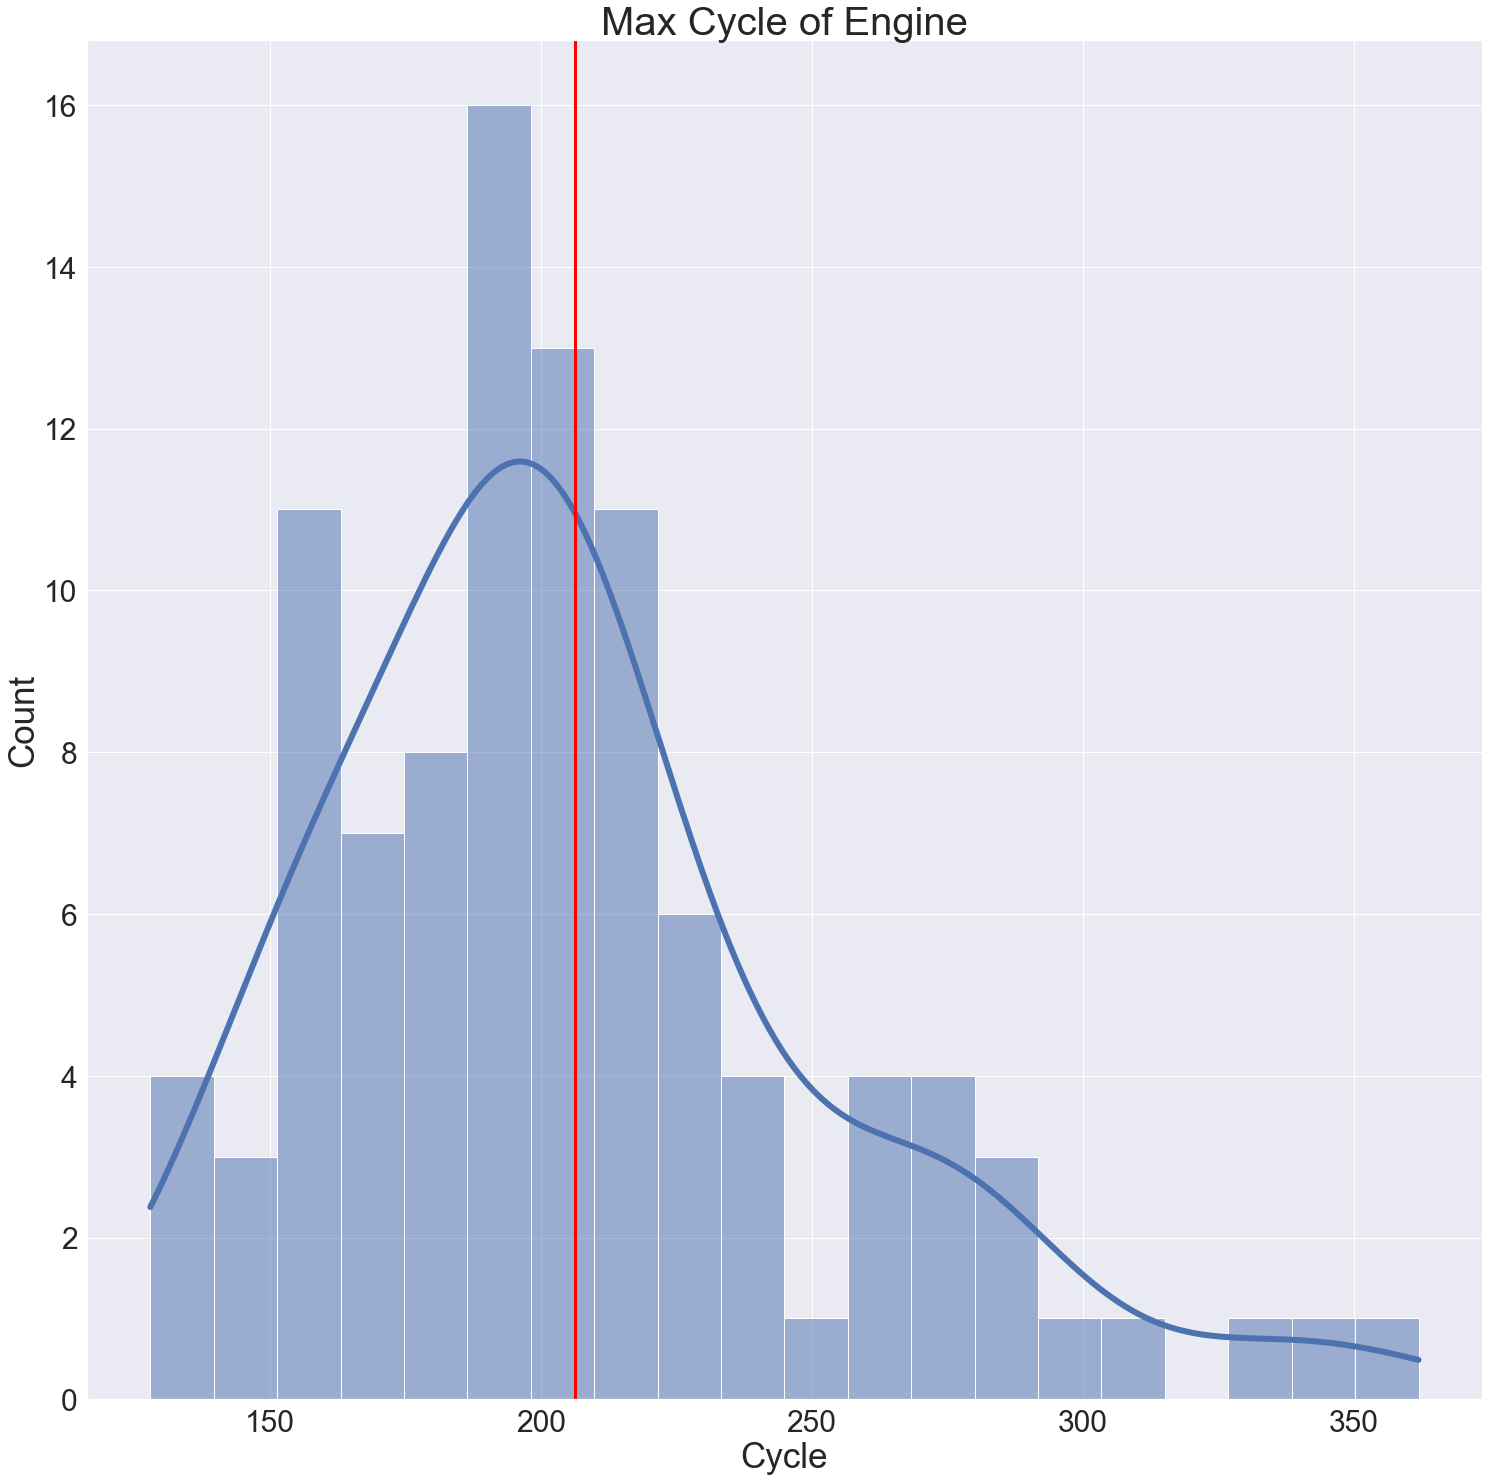

In [472]:
Max_cycle = train.groupby(by='Engine').Cycle.max()#최대사용횟수
Max_cycle_df = pd.DataFrame(Max_cycle)

plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
plt.rc('axes', labelsize=35)
plt.rc('axes', titlesize=40)
sns.set_context(rc={"lines.linewidth": 6})
sns.histplot(data=Max_cycle_df,x='Cycle',kde=True,bins=20)
plt.title('Max Cycle of Engine')
sns.set_context(rc={"lines.linewidth": 3})
plt.axvline(Max_cycle_df.mean()[0],0,1,color='red')
plt.show()
# Max_cycle_df.mean()

엔진의 최대수명에 대한 히스토그램을 살펴보면 `Positive Skew`된 형태를 띄고있다.<br>

보통 이런 경우 log변환을 통해 정규분포처럼 만들 수 있으나 이번 모델의 Target은 RUL이고, RUL은 `Max_cycle` - `Cycle`로 계산되기 때문에 `Max_cycle`의 분포는 크게 상관없을 것으로 판단된다. 추후 모델의 성능이 높지 않다면 log변환도 고려해보도록 한다.<br>

따라서 이 그래프는 단지 Engine의 최대수명의 분포정도로만  파악하는 것이 좋다.
대부분의 Engine은 200번 정도 사용하면 최대수명에 도달하는 것을 알 수 있다.

In [473]:
# Target RUL 
train['Max_cycle']=train.merge(Max_cycle_df,left_on='Engine',right_on='Engine').iloc[:,-1]
train['RUL'] = train['Max_cycle'] - train['Cycle']
train.drop(columns=['Max_cycle','Engine'],inplace=True)
train

,Cycle,Setting_1,Setting_2,Setting_3,Fan_inlet_T,LPC_outlet_T,HPC_outlet_T,LPT_outlet_T,Fan_inlet_P,bypass_duct_P,...,Corrected_fan_S,Corrected_core_S,Bypass_R,Burner_f_a_R,BE,Requried_fan_S,Requried_fan_Conv_S,HP_turbines_Caf,LP_turbines_Caf,RUL
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


우선 상관계수를 이용하여 RUL예측과 상관이 없는 특성은 제거하여 준다.

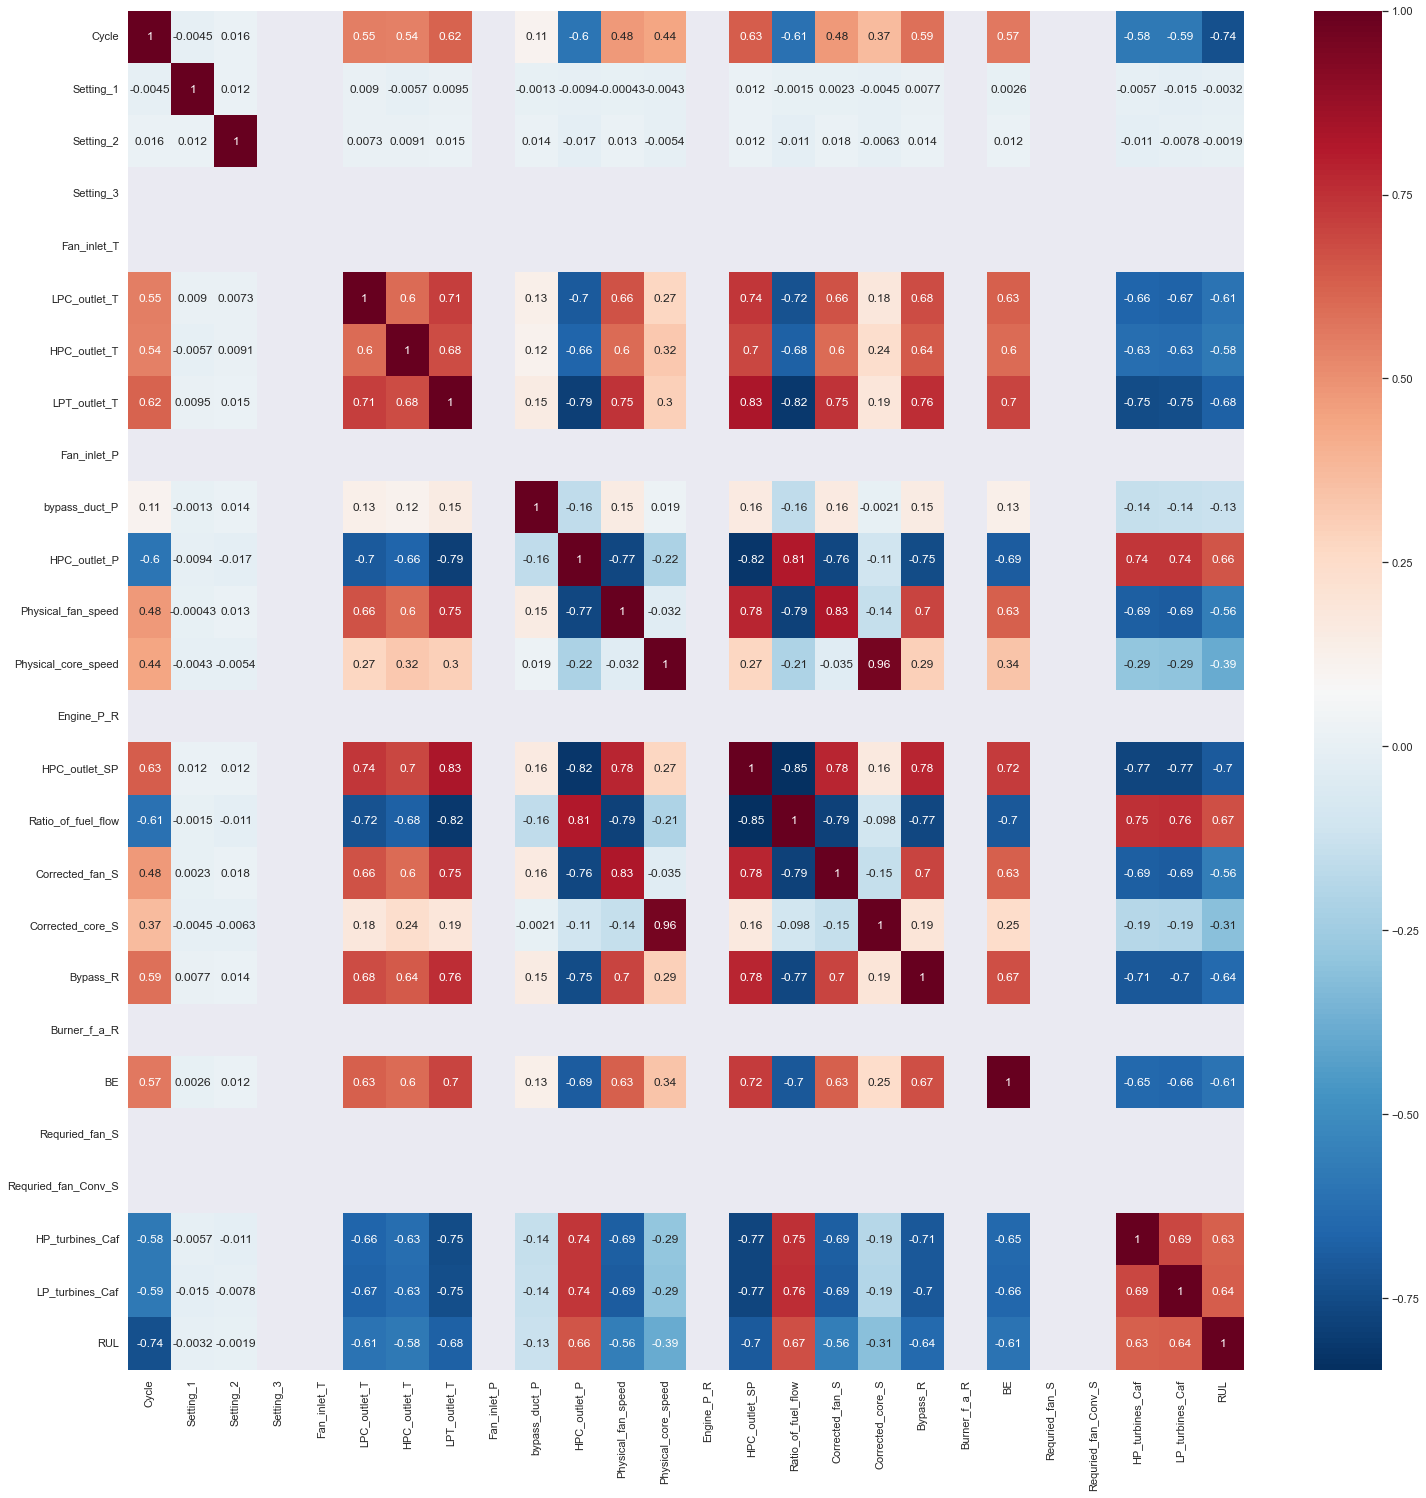

In [296]:
# 상관계수 히트맵
corr = train.corr()
sns.set(rc={'figure.figsize':(25,25)})
sns.heatmap(corr,annot=True,cmap="RdBu_r")
plt.show()

상관계수를 나타낸 Heatmap을 살펴보면 Constant값을 가지는 특성들은 RUL과 어떠한 연관성도 없는 것을 확인할 수 있다. 따라서 예측시에 불필요한 특성으로 판단되기 때문에 제거하여 주도록 한다.<br>
Setting특성들은 사실상 모두 상수와 마찬가지이므로 Setting_1,2 역시 제거한다.<br>
또한 관습적으로 상관계수가 0.4이하이면 대체로 상관관계가 거의 없다고 보기 때문에 RUL과 0.4미만의 상관계수를 가지는 특성은 제거하여 준다.<br>

In [474]:
drop_cols = corr.RUL[~(abs(corr.RUL) >=0.4)].index
train.drop(columns=drop_cols,inplace=True)
X_test.drop(columns=drop_cols,inplace=True)
train.head()

,Cycle,LPC_outlet_T,HPC_outlet_T,LPT_outlet_T,HPC_outlet_P,Physical_fan_speed,HPC_outlet_SP,Ratio_of_fuel_flow,Corrected_fan_S,Bypass_R,BE,HP_turbines_Caf,LP_turbines_Caf,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


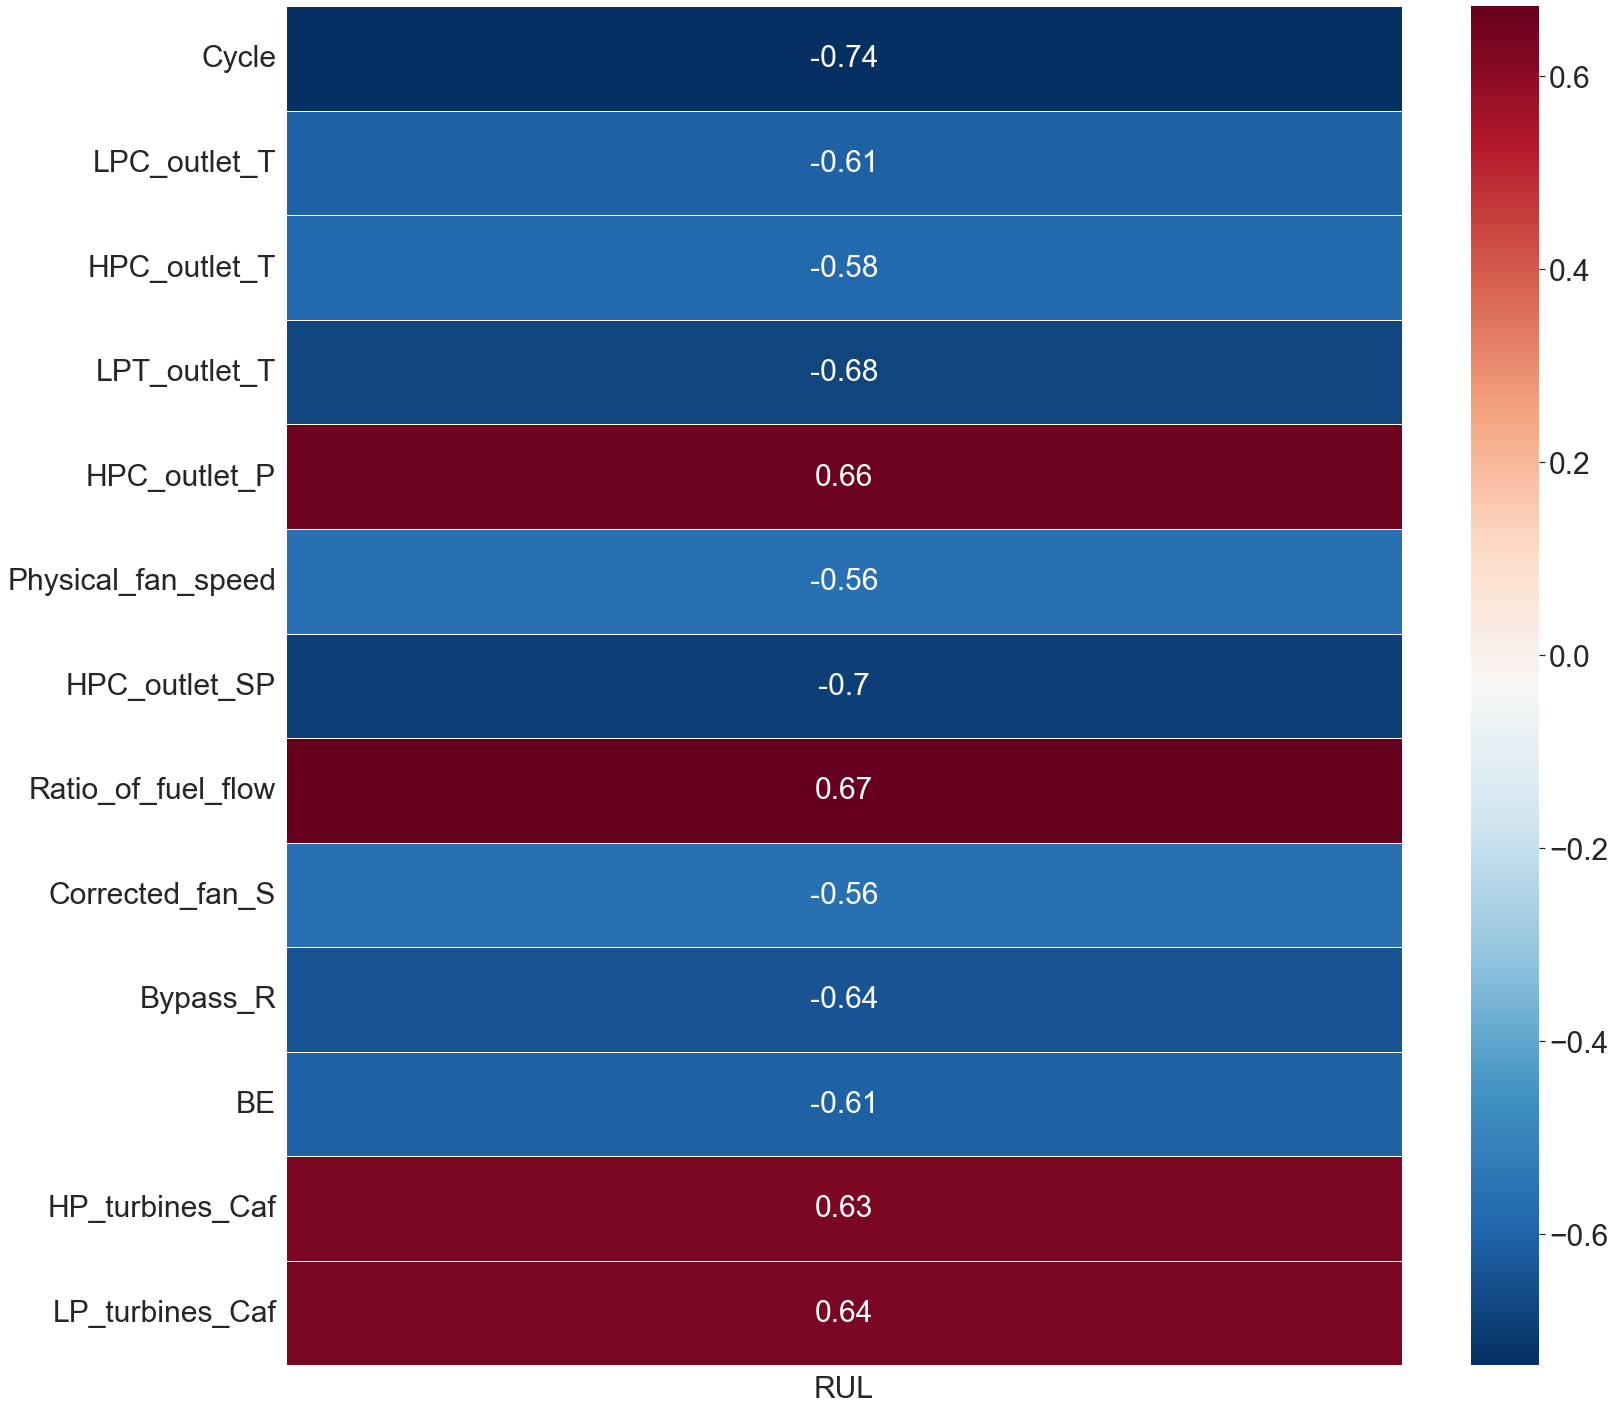

In [475]:
corr_2 = train.corr()
sns.set(rc={'figure.figsize':(25,25)})
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
plt.rc('axes', labelsize=35)
plt.rc('axes', titlesize=40)
sns.heatmap(pd.DataFrame(corr_2.iloc[-1,:-1]),annot=True,cmap="RdBu_r",
           linewidths=.5,annot_kws={"size": 30})
plt.show()

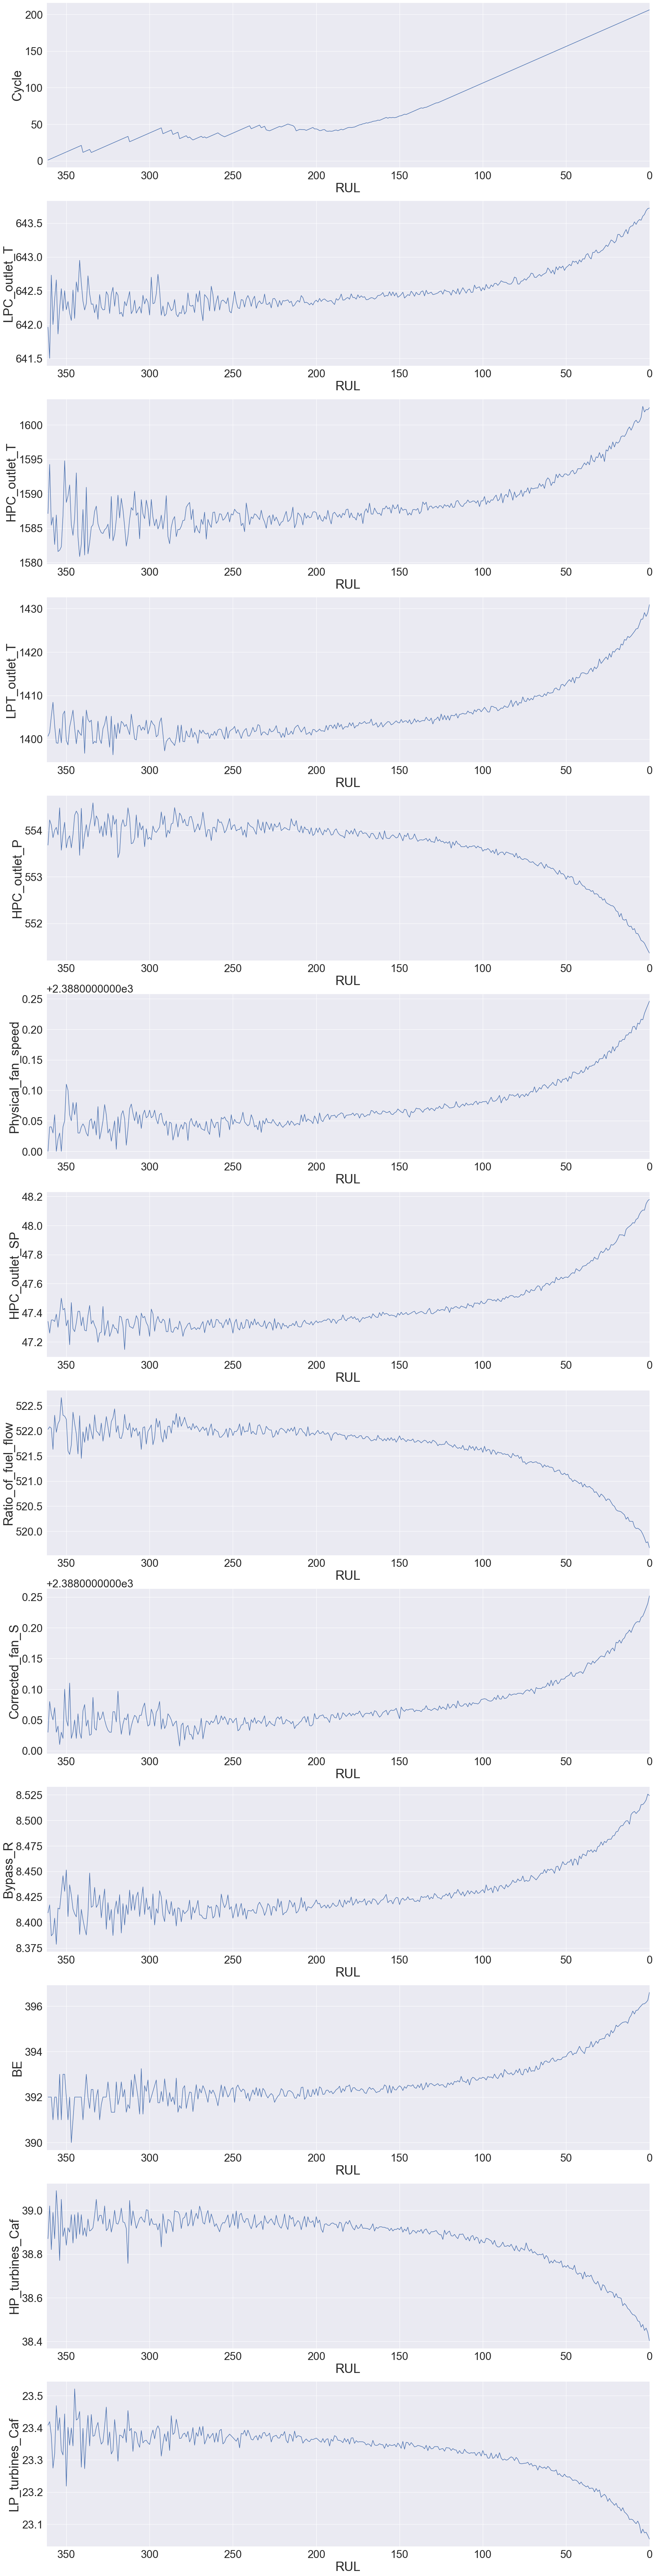

In [476]:
plot_df = train.groupby('RUL').mean()
max_RUL,col_num = plot_df.shape 
plt.figure(figsize = (30,130))
for i in range(col_num):
    plt.subplot(col_num,1,i+1)
    plt.plot(plot_df.iloc[:,i])
    plt.ylabel(plot_df.columns[i])
    plt.xlim(max_RUL,0)
    plt.xlabel('RUL')
plt.show()

위의 그래프를 살펴보면 RUL이 50정도 남기 시작할 때부터 값이 급격히 변하는 것을 확인할 수 있다.

## 모델선정

In [477]:
# Baseline Model
# RUL의 평균값으로 예측했을 때 R2와 RMSE값을 계산하여 보겠다.
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

RUL_mean = train.RUL.mean()
Base_line = [RUL_mean]*train.shape[0]
RMSE_base = mean_squared_error(train.RUL,Base_line,squared=False)
R2_base = r2_score(train.RUL,Base_line)

print(f'Base line Model의 RMSE: {RMSE_base}\nBase line Model의 R2: {R2_base}')

Base line Model의 RMSE: 68.87932080043385
Base line Model의 R2: 0.0


In [478]:
# Target 분리
target = 'RUL'
features = train.drop(columns=target).columns
X = train[features]
y = train[target]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [302]:
! pip3 install xgboost

In [459]:
# 스케일링
# 각 특성의 범위가 다르기 때문에 정규화를 시켜주어야 한다.
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

pipe_ridge = make_pipeline(MinMaxScaler(),
                         RidgeCV())

pipe_ridge.fit(X_train,y_train)

y_rid_pred_train=pipe_ridge.predict(X_train)
y_rid_pred=pipe_ridge.predict(X_val)

RMSE_ridge_train = mean_squared_error(y_train,y_rid_pred_train,squared=False)
R2_ridge_train = r2_score(y_train,y_rid_pred_train)
RMSE_ridge = mean_squared_error(y_val,y_rid_pred,squared=False)
R2_ridge = r2_score(y_val,y_rid_pred)

print("RMSE(train set):", RMSE_ridge_train)
print('R2 score (train set):',R2_ridge_train)
print("")
print("RMSE(val set):",RMSE_ridge)
print('R2 score (val set):',R2_ridge)

RMSE(train set): 40.863921578093795
R2 score (train set): 0.6512373050692211

RMSE(val set): 39.89975656899688
R2 score (val set): 0.6515513322827787


In [304]:
# GridSearch로 찾아보기-XGB
pipe_XGB = make_pipeline(MinMaxScaler(),
                        XGBRegressor(random_state=42))

dists_XGB = {
    'xgbregressor__n_estimators': np.arange(80,150,10), 
    'xgbregressor__max_depth': np.arange(5,10),
    'xgbregressor__learning_rate':np.arange(0.05,0.1,0.01)
}

clf_XGB = GridSearchCV(
    pipe_XGB, 
    param_grid=dists_XGB, 
    cv=3, 
    scoring='neg_root_mean_squared_error',  
    verbose=2,
    n_jobs= -1
)

clf_XGB.fit(X_train, y_train)

y_pred_XGB_val = clf_XGB.best_estimator_.predict(X_val)
y_pred_XGB_train = clf_XGB.best_estimator_.predict(X_train)
R2_XGB_val = r2_score(y_val,y_pred_XGB_val)
R2_XGB_train = r2_score(y_train,y_pred_XGB_train)

print("Optimal Hyperparameter:", clf_XGB.best_params_)
print("")
print("RMSE(train set):", -clf_XGB.best_score_)
print('R2 score (train set):',R2_XGB_train)
print("")
print("RMSE(val set):",mean_squared_error(y_val,y_pred_XGB_val,squared=False))
print('R2 score (val set):',R2_XGB_val)

Fitting 3 folds for each of 175 candidates, totalling 525 fits
Optimal Hyperparameter: {'xgbregressor__learning_rate': 0.060000000000000005, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 90}

RMSE(train set): 37.39166113043057
R2 score (train set): 0.749012047673044

RMSE(val set): 36.66515374839973
R2 score (val set): 0.7057575437922408


In [305]:
#GridSearch로 찾아보기-SVR
pipe_SVR = make_pipeline(MinMaxScaler(),
                        SVR())

dists_SVR = {
    'svr__kernel':['rbf','poly','linear'],
    'svr__gamma':np.arange(0.5,1,0.1),
    'svr__epsilon':np.arange(0.5,1.5,0.1)
}
clf_SVR = GridSearchCV(
    pipe_SVR, 
    param_grid=dists_SVR, 
    cv=3, 
    scoring='neg_root_mean_squared_error',  
    verbose=2,
    n_jobs= -1
)

clf_SVR.fit(X_train, y_train)

y_pred_SVR_val = clf_SVR.best_estimator_.predict(X_val)
y_pred_SVR_train = clf_SVR.best_estimator_.predict(X_train)
R2_SVR_val = r2_score(y_val,y_pred_SVR_val)
R2_SVR_train = r2_score(y_train,y_pred_SVR_train)

print("Optimal Hyperparameter:", clf_SVR.best_params_)
print("")
print("RMSE(train set):", -clf_SVR.best_score_)
print('R2 score (train set):',R2_SVR_train)
print("")
print("RMSE(val set):",mean_squared_error(y_val,y_pred_SVR_val,squared=False))
print('R2 score (val set):',R2_SVR_val)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Optimal Hyperparameter: {'svr__epsilon': 1.4, 'svr__gamma': 0.8999999999999999, 'svr__kernel': 'poly'}

RMSE(train set): 39.329491831412575
R2 score (train set): 0.6807052634945052

RMSE(val set): 38.339815738016796
R2 score (val set): 0.678264962487168


In [306]:
# GridSearch로 찾아보기-RandomForest
pipe_RFR = make_pipeline(MinMaxScaler(),
                        RandomForestRegressor())

dists_RFR = {
    'randomforestregressor__n_estimators':np.arange(500,600,100),
    'randomforestregressor__max_depth':np.arange(12,15),
    'randomforestregressor__criterion':['squared_error','absolute_error','poisson'],
    'randomforestregressor__max_features':['sqrt','log2'] 
}

clf_RFR = GridSearchCV(
    pipe_RFR, 
    param_grid=dists_RFR, 
    cv=3, 
    scoring='neg_root_mean_squared_error',  
    verbose=2,
    n_jobs= -1
)

clf_RFR.fit(X_train, y_train)

y_pred_RFR_val = clf_RFR.best_estimator_.predict(X_val)
y_pred_RFR_train = clf_RFR.best_estimator_.predict(X_train)
R2_RFR_val = r2_score(y_val,y_pred_RFR_val)
R2_RFR_train = r2_score(y_train,y_pred_RFR_train)

print("Optimal Hyperparameter:", clf_RFR.best_params_)
print("")
print("RMSE(train set):", -clf_RFR.best_score_)
print('R2 score (train set):',R2_RFR_train)
print("")
print("RMSE(val set):",mean_squared_error(y_val,y_pred_RFR_val,squared=False))
print('R2 score (val set):',R2_RFR_val)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Optimal Hyperparameter: {'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_depth': 13, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 500}

RMSE(train set): 37.36928854199059
R2 score (train set): 0.8689145553347254

RMSE(val set): 36.83854546445682
R2 score (val set): 0.7029679828258856


 XGBoost가 가장 좋은 성능지표를 보여준다. 따라서 XGBoost모델을 통하여 조금 더 상세한 정보를 보도록 하겠다.

In [ ]:
!pip install eli5

In [307]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    clf_XGB.best_estimator_.named_steps['xgbregressor'], # model
    scoring='neg_root_mean_squared_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_val_transformed = clf_XGB.best_estimator_.named_steps['minmaxscaler'].transform(X_val)
permuter.fit(X_val_transformed, y_val);

feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)


Weight,Feature
26.6095 ± 0.6976,Cycle
1.9492 ± 0.2074,HPC_outlet_SP
0.8280 ± 0.2275,LPT_outlet_T
0.4386 ± 0.1004,Bypass_R
0.3551 ± 0.0791,LP_turbines_Caf
0.3375 ± 0.0863,LPC_outlet_T
0.3369 ± 0.0327,HP_turbines_Caf
0.3300 ± 0.0690,Corrected_fan_S
0.3273 ± 0.0618,HPC_outlet_P
0.3075 ± 0.1107,Ratio_of_fuel_flow


순열중요도를 통해서 확인해본 결과 성능지표에 부정적인 영향을 미치는 특성은 없는 것으로 판단된다.<br>

특히 순열중요도에서 Cycle의 순열중요도가 가장 높게 나온다. 데이터누수가 의심되는 상황이긴 하지만 실제로 엔진의 수명에서 사용횟수가 가장 중요한 지표이기도 하고, 엔진을 사용할 때 최대수명을 알 수 없기 때문에 데이터 누수라고 판단하지 않아서 특성을 제거하지 않았다.

In [308]:
# GridSearch로 찾아보기-XGB
pipe_XGB = make_pipeline(MinMaxScaler(),
                        XGBRegressor(random_state=42))

dists_XGB = {
    'xgbregressor__n_estimators': np.arange(100,200,10), 
    'xgbregressor__max_depth': np.arange(5,10),
    'xgbregressor__learning_rate':np.arange(0.05,0.1,0.01)
}

clf_XGB = GridSearchCV(
    pipe_XGB, 
    param_grid=dists_XGB, 
    cv=3, 
    scoring='neg_root_mean_squared_error',  
    verbose=2,
    n_jobs= -1
)

clf_XGB.fit(X_train, y_train)

y_pred_XGB_val = clf_XGB.best_estimator_.predict(X_val)
y_pred_XGB_train = clf_XGB.best_estimator_.predict(X_train)
R2_XGB_val = r2_score(y_val,y_pred_XGB_val)
R2_XGB_train = r2_score(y_train,y_pred_XGB_train)

print("Optimal Hyperparameter:", clf_XGB.best_params_)
print("")
print("RMSE(train set):", -clf_XGB.best_score_)
print('R2 score (train set):',R2_XGB_train)
print("")
print("RMSE(val set):",mean_squared_error(y_val,y_pred_XGB_val,squared=False))
print('R2 score (val set):',R2_XGB_val)

Fitting 3 folds for each of 250 candidates, totalling 750 fits
Optimal Hyperparameter: {'xgbregressor__learning_rate': 0.060000000000000005, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 100}

RMSE(train set): 37.41400516017196
R2 score (train set): 0.7512302688981365

RMSE(val set): 36.6677542051787
R2 score (val set): 0.7057158043286829


여전히 RMSE가 높다고 판단되어 특성공학을 다시 진행하였다.

In [479]:
train = pd.read_csv('train_FD001.txt',sep = '\s+',names = col_name) 
X_test = pd.read_csv('test_FD001.txt',sep='\s+',names = col_name)

Max_cycle = train.groupby(by='Engine').Cycle.max()
Max_cycle_df = pd.DataFrame(Max_cycle)

train['Max_cycle']=train.merge(Max_cycle_df,left_on='Engine',right_on='Engine').iloc[:,-1]
train['RUL'] = train['Max_cycle'] - train['Cycle']
train.drop(columns=['Max_cycle','Engine'],inplace=True)
X_test.drop(columns=['Engine'],inplace=True)

drop_cols = corr.RUL[corr.RUL.isnull()].index
train.drop(columns=drop_cols,inplace=True)
X_test.drop(columns=drop_cols,inplace=True)

In [480]:
# Target 분리
target = 'RUL'
features = train.drop(columns=target).columns
X = train[features]
y = train[target]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [311]:
# GridSearch로 찾아보기-XGB
pipe_XGB = make_pipeline(MinMaxScaler(),
                        XGBRegressor(random_state=42))

dists_XGB = {
    'xgbregressor__n_estimators': np.arange(100,1000,100), 
    'xgbregressor__max_depth': np.arange(5,10),
    'xgbregressor__learning_rate':np.arange(0.05,0.1,0.01)
}

clf_XGB = GridSearchCV(
    pipe_XGB, 
    param_grid=dists_XGB, 
    cv=3, 
    scoring='neg_root_mean_squared_error',  
    verbose=2,
    n_jobs= -1
)

clf_XGB.fit(X_train, y_train)

y_pred_XGB_val = clf_XGB.best_estimator_.predict(X_val)
y_pred_XGB_train = clf_XGB.best_estimator_.predict(X_train)
R2_XGB_val = r2_score(y_val,y_pred_XGB_val)
R2_XGB_train = r2_score(y_train,y_pred_XGB_train)

print("Optimal Hyperparameter:", clf_XGB.best_params_)
print("")
print("RMSE(train set):", -clf_XGB.best_score_)
print('R2 score (train set):',R2_XGB_train)
print("")
print("RMSE(val set):",mean_squared_error(y_val,y_pred_XGB_val,squared=False))
print('R2 score (val set):',R2_XGB_val)

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Optimal Hyperparameter: {'xgbregressor__learning_rate': 0.060000000000000005, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 100}

RMSE(train set): 36.1018185997859
R2 score (train set): 0.7705930448695602

RMSE(val set): 35.55017290106149
R2 score (val set): 0.7233811631275877


In [312]:
permuter = PermutationImportance(
    clf_XGB.best_estimator_.named_steps['xgbregressor'], # model
    scoring='neg_root_mean_squared_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_val_transformed = clf_XGB.best_estimator_.named_steps['minmaxscaler'].transform(X_val)

permuter.fit(X_val_transformed, y_val);
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)


Weight,Feature
23.8999 ± 0.9445,Cycle
1.6175 ± 0.1837,Physical_core_speed
1.5679 ± 0.2193,HPC_outlet_SP
1.0008 ± 0.1344,Corrected_core_S
0.5785 ± 0.1265,LPT_outlet_T
0.4576 ± 0.1329,HPC_outlet_P
0.4322 ± 0.0890,Ratio_of_fuel_flow
0.2708 ± 0.0487,Bypass_R
0.2108 ± 0.0811,LPC_outlet_T
0.1609 ± 0.1122,Physical_fan_speed


In [481]:
X_train.drop(columns=['Setting_1','Setting_2','bypass_duct_P'],inplace=True)
X_val.drop(columns=['Setting_1','Setting_2','bypass_duct_P'],inplace=True)
X_test.drop(columns=['Setting_1','Setting_2','bypass_duct_P'],inplace=True)

In [315]:
# GridSearch로 찾아보기-XGB
pipe_XGB = make_pipeline(MinMaxScaler(),
                        XGBRegressor(random_state=42,
                                    tree_method='gpu_hist',
                                     gpu_id=0))

dists_XGB = {
    'xgbregressor__n_estimators': np.arange(100,200,10), 
    'xgbregressor__max_depth': np.arange(3,7),
    'xgbregressor__learning_rate':np.arange(0.03,0.1,0.01)
}

clf_XGB = GridSearchCV(
    pipe_XGB, 
    param_grid=dists_XGB, 
    cv=3, 
    scoring='neg_root_mean_squared_error',  
    verbose=2,
    n_jobs= -1
)

clf_XGB.fit(X_train, y_train)

y_pred_XGB_val = clf_XGB.best_estimator_.predict(X_val)
y_pred_XGB_train = clf_XGB.best_estimator_.predict(X_train)
R2_XGB_val = r2_score(y_val,y_pred_XGB_val)
R2_XGB_train = r2_score(y_train,y_pred_XGB_train)

print("Optimal Hyperparameter:", clf_XGB.best_params_)
print("")
print("RMSE(train set):", -clf_XGB.best_score_)
print('R2 score (train set):',R2_XGB_train)
print("")
print("RMSE(val set):",mean_squared_error(y_val,y_pred_XGB_val,squared=False))
print('R2 score (val set):',R2_XGB_val)

Fitting 3 folds for each of 320 candidates, totalling 960 fits
Optimal Hyperparameter: {'xgbregressor__learning_rate': 0.07, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 100}

RMSE(train set): 36.060664342201825
R2 score (train set): 0.7548705054399287

RMSE(val set): 35.554520168419764
R2 score (val set): 0.7233135060970652


아무래도 이전에 처리해주지 않은 Max Cycle의 문제라고 판단됨.

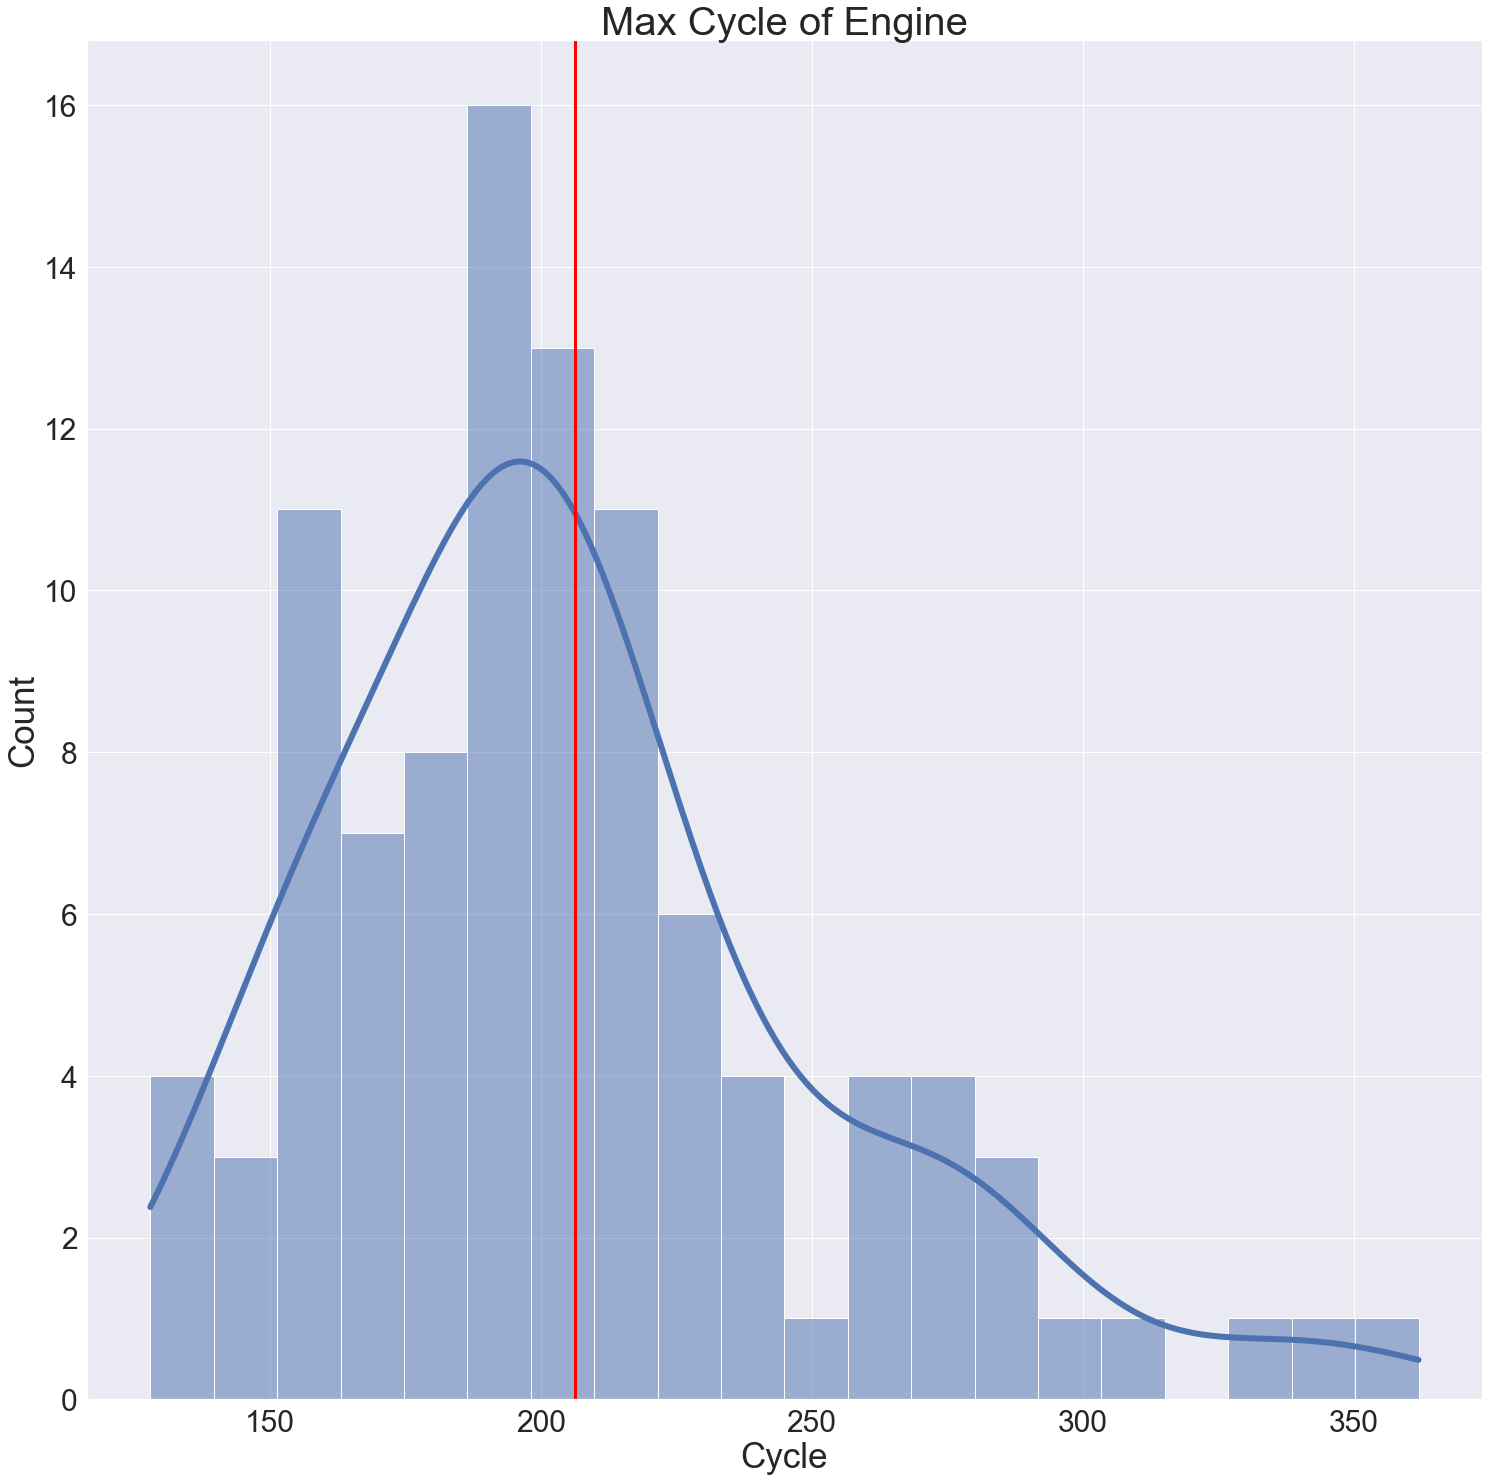

In [482]:
train = pd.read_csv('train_FD001.txt',sep = '\s+',names = col_name) 
X_test = pd.read_csv('test_FD001.txt',sep='\s+',names = col_name)

Max_cycle = train.groupby(by='Engine').Cycle.max()
Max_cycle_df = pd.DataFrame(Max_cycle)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
plt.rc('axes', labelsize=35)
plt.rc('axes', titlesize=40)
sns.set_context(rc={"lines.linewidth": 6})
sns.histplot(data=Max_cycle_df,x='Cycle',kde=True,bins=20)
plt.title('Max Cycle of Engine')
sns.set_context(rc={"lines.linewidth": 3})
plt.axvline(Max_cycle_df.mean()[0],0,1,color='red')
plt.show()

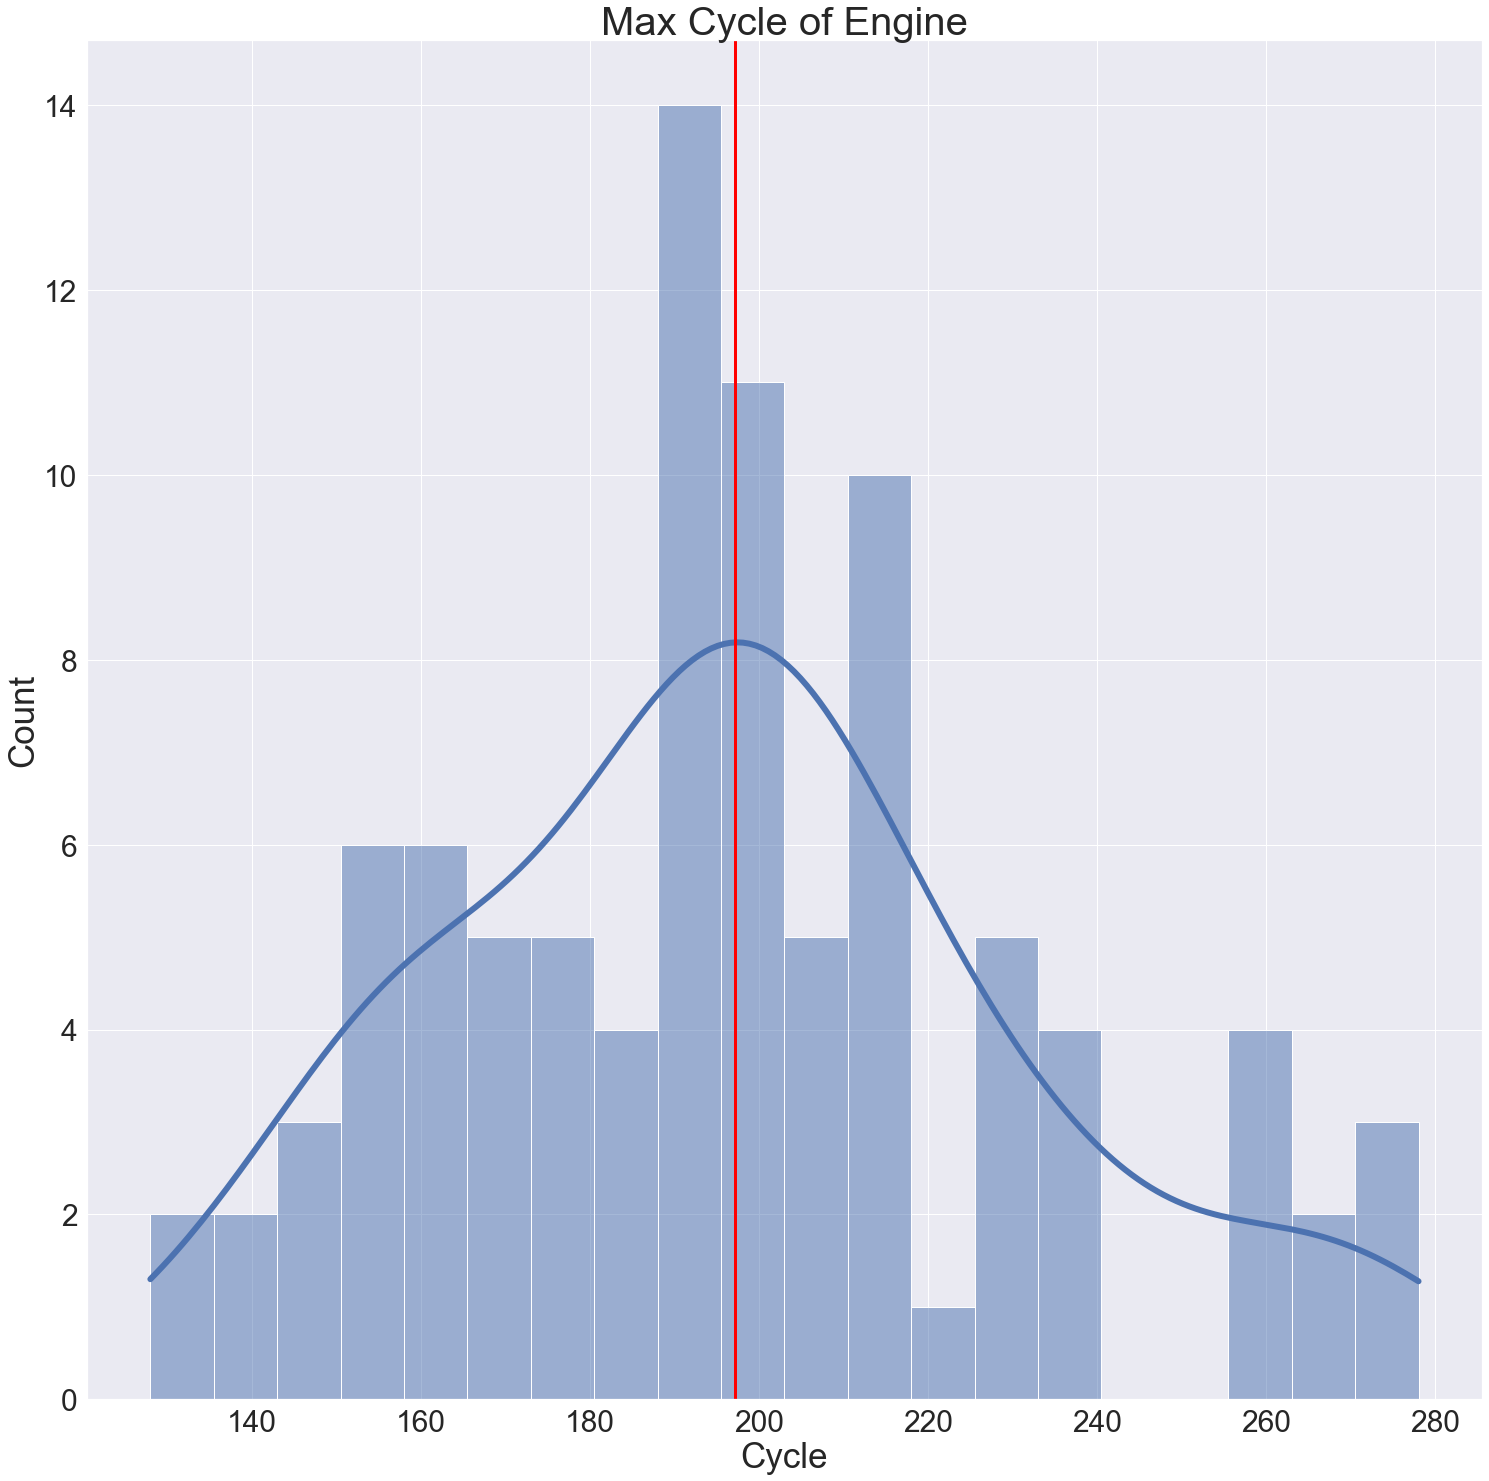

In [483]:
train['Max_cycle']=train.merge(Max_cycle_df,left_on='Engine',right_on='Engine').iloc[:,-1]
drop_line=np.quantile(train['Max_cycle'],0.9)
drop_index = train['Max_cycle'][train['Max_cycle']>= drop_line].index
train.drop(index = drop_index,inplace=True)
train.reset_index(inplace=True,drop=True)

Max_cycle = train.groupby(by='Engine').Cycle.max()
Max_cycle_df = pd.DataFrame(Max_cycle)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
plt.rc('axes', labelsize=35)
plt.rc('axes', titlesize=40)
sns.set_context(rc={"lines.linewidth": 6})
sns.histplot(data=Max_cycle_df,x='Cycle',kde=True,bins=20)
plt.title('Max Cycle of Engine')
sns.set_context(rc={"lines.linewidth": 3})
plt.axvline(Max_cycle_df.mean()[0],0,1,color='red')
plt.show()

In [485]:
train['RUL'] = train['Max_cycle'] - train['Cycle']
train.drop(columns=['Max_cycle','Engine'],inplace=True)
X_test.drop(columns=['Engine'],inplace=True)

drop_cols = corr.RUL[corr.RUL.isnull()].index
train.drop(columns=drop_cols,inplace=True)
X_test.drop(columns=drop_cols,inplace=True)

In [486]:
# Target 분리
target = 'RUL'
features = train.drop(columns=target).columns
X = train[features]
y = train[target]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [487]:
X_train.drop(columns=['Setting_1','Setting_2','bypass_duct_P'],inplace=True)
X_val.drop(columns=['Setting_1','Setting_2','bypass_duct_P'],inplace=True)

In [352]:
# GridSearch로 찾아보기-XGB
pipe_XGB = make_pipeline(MinMaxScaler(),
                        XGBRegressor(random_state=42,
                                    tree_method='gpu_hist',
                                     gpu_id=0))

dists_XGB = {
    'xgbregressor__n_estimators': np.arange(400,900,100), 
    'xgbregressor__max_depth': np.arange(3,8),
    'xgbregressor__learning_rate':np.arange(0.03,0.1,0.01)
}

clf_XGB = GridSearchCV(
    pipe_XGB, 
    param_grid=dists_XGB, 
    cv=3, 
    scoring='neg_root_mean_squared_error',  
    verbose=2,
    n_jobs= -1
)

clf_XGB.fit(X_train, y_train)

y_pred_XGB_val = clf_XGB.best_estimator_.predict(X_val)
y_pred_XGB_train = clf_XGB.best_estimator_.predict(X_train)
R2_XGB_val = r2_score(y_val,y_pred_XGB_val)
R2_XGB_train = r2_score(y_train,y_pred_XGB_train)

print("Optimal Hyperparameter:", clf_XGB.best_params_)
print("")
print("RMSE(train set):", -clf_XGB.best_score_)
print('R2 score (train set):',R2_XGB_train)
print("")
print("RMSE(val set):",mean_squared_error(y_val,y_pred_XGB_val,squared=False))
print('R2 score (val set):',R2_XGB_val)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Optimal Hyperparameter: {'xgbregressor__learning_rate': 0.03, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 400}

RMSE(train set): 27.021886469688187
R2 score (train set): 0.85557784921875

RMSE(val set): 26.544408576351067
R2 score (val set): 0.8169278849576989


In [353]:
permuter = PermutationImportance(
    clf_XGB.best_estimator_.named_steps['xgbregressor'], # model
    scoring='neg_root_mean_squared_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_val_transformed = clf_XGB.best_estimator_.named_steps['minmaxscaler'].transform(X_val)

permuter.fit(X_val_transformed, y_val);
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
33.7134 ± 0.9154,Cycle
1.5100 ± 0.1797,HPC_outlet_SP
1.0738 ± 0.2069,Physical_core_speed
0.8959 ± 0.1249,LPT_outlet_T
0.8223 ± 0.1163,Ratio_of_fuel_flow
0.6601 ± 0.0830,Corrected_core_S
0.3461 ± 0.1026,HPC_outlet_P
0.3055 ± 0.1005,Physical_fan_speed
0.2987 ± 0.0750,Bypass_R
0.2848 ± 0.0810,LPC_outlet_T


In [364]:
# GridSearch로 찾아보기-XGB
pipe_XGB = make_pipeline(MinMaxScaler(),
                        XGBRegressor(random_state=42,
                                    tree_method='gpu_hist',
                                     gpu_id=0))

dists_XGB = {
    'xgbregressor__n_estimators': np.arange(390,405,1), 
    'xgbregressor__max_depth': np.arange(4,6),
    'xgbregressor__learning_rate':np.arange(0.026,0.027,0.0001)
}

clf_XGB = GridSearchCV(
    pipe_XGB, 
    param_grid=dists_XGB, 
    cv=3, 
    scoring='neg_root_mean_squared_error',  
    verbose=2,
    n_jobs= -1
)

clf_XGB.fit(X_train, y_train)

y_pred_XGB_val = clf_XGB.best_estimator_.predict(X_val)
y_pred_XGB_train = clf_XGB.best_estimator_.predict(X_train)
R2_XGB_val = r2_score(y_val,y_pred_XGB_val)
R2_XGB_train = r2_score(y_train,y_pred_XGB_train)

print("Optimal Hyperparameter:", clf_XGB.best_params_)
print("")
print("RMSE(train set):", -clf_XGB.best_score_)
print('R2 score (train set):',R2_XGB_train)
print("")
print("RMSE(val set):",mean_squared_error(y_val,y_pred_XGB_val,squared=False))
print('R2 score (val set):',R2_XGB_val)

Fitting 3 folds for each of 330 candidates, totalling 990 fits
Optimal Hyperparameter: {'xgbregressor__learning_rate': 0.026, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 391}

RMSE(train set): 26.978989942370244
R2 score (train set): 0.8500275477015047

RMSE(val set): 26.568891625092423
R2 score (val set): 0.8165900186572403


In [494]:
X_test = pd.read_csv('test_FD001.txt',sep='\s+',names = col_name)
test_RUL = pd.read_csv('RUL_FD001.txt',sep='\s+',names = ['RUL'])
Max_cycle = X_test.groupby(by='Engine').Cycle.max()
Max_cycle_df = pd.DataFrame(Max_cycle)

for i in range(100):
    Max_cycle_df.iloc[i] = Max_cycle_df.Cycle.iloc[i] + test_RUL.RUL.iloc[i]

X_test['Max_cycle']=X_test.merge(Max_cycle_df,left_on='Engine',right_on='Engine').iloc[:,-1]

X_test['RUL'] = X_test['Max_cycle'] - X_test['Cycle']
X_test.drop(columns=['Engine','Max_cycle'],inplace=True)
X_test.drop(columns=drop_cols,inplace=True)

X_test.drop(columns=['Setting_1','Setting_2','bypass_duct_P'],inplace=True)

y_test = X_test[target]
X_test.drop(columns = 'RUL',inplace=True)

In [495]:
y_pred_XGB = clf_XGB.best_estimator_.predict(X_test)
R2_XGB = r2_score(y_test,y_pred_XGB)

print("RMSE(test set):",mean_squared_error(y_test,y_pred_XGB,squared=False))
print('R2 score (test set):',R2_XGB)

RMSE(test set): 42.74386908724904
R2 score (test set): 0.4747457087060558


In [496]:
X_test = pd.read_csv('test_FD001.txt',sep='\s+',names = col_name)
test_RUL = pd.read_csv('RUL_FD001.txt',sep='\s+',names = ['RUL'])
Max_cycle = X_test.groupby(by='Engine').Cycle.max()
Max_cycle_df = pd.DataFrame(Max_cycle)

for i in range(100):
    Max_cycle_df.iloc[i] = Max_cycle_df.Cycle.iloc[i] + test_RUL.RUL.iloc[i]

X_test['Max_cycle']=X_test.merge(Max_cycle_df,left_on='Engine',right_on='Engine').iloc[:,-1]

drop_index = X_test['Max_cycle'][X_test['Max_cycle']>= drop_line].index
X_test.drop(index = drop_index,inplace=True)
X_test.reset_index(inplace=True,drop=True)

X_test['RUL'] = X_test['Max_cycle'] - X_test['Cycle']
X_test.drop(columns=['Engine','Max_cycle'],inplace=True)
X_test.drop(columns=drop_cols,inplace=True)

X_test.drop(columns=['Setting_1','Setting_2','bypass_duct_P'],inplace=True)

y_test = X_test[target]
X_test.drop(columns = 'RUL',inplace=True)

In [497]:
y_pred_XGB = clf_XGB.best_estimator_.predict(X_test)
R2_XGB = r2_score(y_test,y_pred_XGB)

print("RMSE(test set):",mean_squared_error(y_test,y_pred_XGB,squared=False))
print('R2 score (test set):',R2_XGB)

RMSE(test set): 32.30869766085374
R2 score (test set): 0.6274998950321056


In [ ]:
!pip install shap

In [449]:
scaler = MinMaxScaler()
model = XGBRegressor(random_state=42,tree_method='gpu_hist',gpu_id=0,
                    learning_rate= 0.026, max_depth = 5,
                    n_estimators = 391)

X_train_scaler = scaler.fit_transform(X_train)
model.fit(X_train,y_train)

X_test_scaler = scaler.transform(X_test)
y_pred  = model.predict(X_test_scaler)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


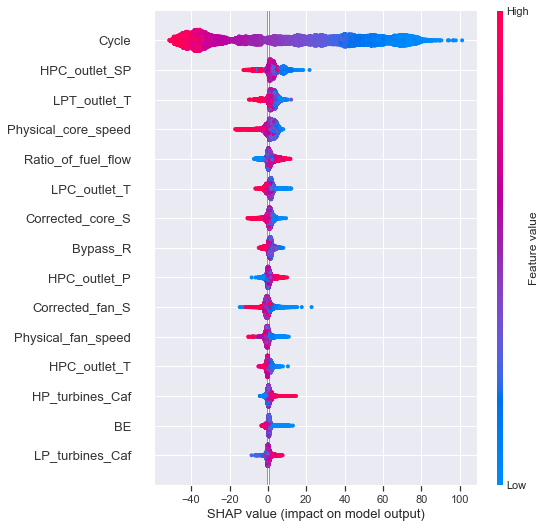

In [450]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [493]:
permuter = PermutationImportance(
    clf_XGB.best_estimator_.named_steps['xgbregressor'], # model
    scoring='neg_root_mean_squared_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_test_transformed = clf_XGB.best_estimator_.named_steps['minmaxscaler'].transform(X_test)

permuter.fit(X_test_transformed, y_test);
feature_names = X_test.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
25.1459 ± 0.2722,Cycle
0.7848 ± 0.0264,Physical_core_speed
0.3737 ± 0.0572,Corrected_core_S
0.1968 ± 0.0489,LPT_outlet_T
0.1639 ± 0.0867,HPC_outlet_SP
0.0671 ± 0.0237,LP_turbines_Caf
0.0320 ± 0.0361,LPC_outlet_T
0.0140 ± 0.0389,BE
0.0049 ± 0.0269,HPC_outlet_T
-0.0043 ± 0.0178,Bypass_R


In [463]:
X_test

,Engine,Cycle,LPC_outlet_T,HPC_outlet_T,LPT_outlet_T,HPC_outlet_P,Physical_fan_speed,HPC_outlet_SP,Ratio_of_fuel_flow,Corrected_fan_S,Bypass_R,BE,HP_turbines_Caf,LP_turbines_Caf
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,47.20,521.72,2388.03,8.4052,392,38.86,23.3735
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,47.50,522.16,2388.06,8.3803,393,39.02,23.3916
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,47.50,521.97,2388.03,8.4441,393,39.08,23.4166
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,47.28,521.38,2388.05,8.3917,391,39.00,23.3737
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,47.31,522.15,2388.03,8.4031,390,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,643.24,1599.45,1415.79,553.41,2388.02,47.69,520.69,2388.00,8.4715,394,38.65,23.1974
13092,100,195,643.22,1595.69,1422.05,553.22,2388.05,47.60,521.05,2388.09,8.4512,395,38.57,23.2771
13093,100,196,643.44,1593.15,1406.82,553.04,2388.11,47.57,521.18,2388.04,8.4569,395,38.62,23.2051
13094,100,197,643.26,1594.99,1419.36,553.37,2388.07,47.61,521.33,2388.08,8.4711,395,38.66,23.2699
